# Flow Dashboard

Display visualizations from Github data.


## Setup


In [47]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from functools import reduce

# Date tools
from datetime import date
from dateutil.relativedelta import relativedelta, SU

# Prep Plots

# Bigger text
plt.rc('font', size=12)


def plotPie(df, title, xLabel):
    def label_point(pct, allvals):
        absolute = int(np.round(pct/100.*np.sum(allvals)))
        return "{:.1f}%\n({:d})".format(pct, absolute)

    print()
    plt.figure(figsize=(10, 5))
    plt.title(title, fontsize=20)
    df.sum().plot(kind='pie', legend=False,
                  autopct=lambda pct: label_point(pct, df.sum()),
                  pctdistance=1.16, labeldistance=.4)
    plt.ylabel(None)  # Clear yLabel
    plt.xlabel(xLabel, fontsize=16)
    plt.show()

# Date utils


def get_previous_sunday(working_date=date.today()):
    last_sunday = working_date + relativedelta(weekday=SU(-1))
    return last_sunday.strftime("%Y-%m-%d")


prs = pd.read_csv('prs_data.csv', parse_dates=[
                  'closedAt', 'createdAt', 'updatedAt']).set_index('number')

prs


,title,author,assignees,url,state,closedAt,createdAt,updatedAt,labels,issues
number,,,,,,,,,,
1730,[Critical Bug] Fortnite hosts cant edit game s...,brianmazzocchi,{'brianmazzocchi'},https://github.com/weiks/esports-backend/pull/...,OPEN,NaT,2022-06-30 19:11:47+00:00,2022-06-30 21:06:05+00:00,"{'bug', 'critical'}","[{'assignees': {'brianmazzocchi'}, 'labels': {..."
1732,Paypal payment method,mikiasyonas,{'mikiasyonas'},https://github.com/weiks/esports-backend/pull/...,OPEN,NaT,2022-06-30 20:27:06+00:00,2022-06-30 20:54:04+00:00,"{'enhancement', 'good for newcomers', 'intervi...","[{'assignees': {'mikiasyonas'}, 'labels': {'en..."
1731,Yunite authorize servers button,gonzalovelasco,{'gonzalovelasco'},https://github.com/weiks/esports-backend/pull/...,OPEN,NaT,2022-06-30 19:30:37+00:00,2022-06-30 19:48:07+00:00,set(),[]
1699,1417 enhancement add support for buying quarte...,mikiasyonas,{'mikiasyonas'},https://github.com/weiks/esports-backend/pull/...,CLOSED,2022-06-30 19:25:53+00:00,2022-06-22 12:06:50+00:00,2022-06-30 19:26:02+00:00,"{'enhancement', 'good for newcomers', 'intervi...","[{'assignees': {'mikiasyonas'}, 'labels': {'en..."
1703,Doc: Tech debt plan,bmcilw1,{'bmcilw1'},https://github.com/weiks/esports-backend/pull/...,OPEN,NaT,2022-06-23 16:14:20+00:00,2022-06-30 19:05:24+00:00,{'docs'},[]
...,...,...,...,...,...,...,...,...,...,...
6,Add auth middleware to discord/token endpoint,Mathspy,{'Mathspy'},https://github.com/weiks/esports-backend/pull/6,MERGED,2020-03-18 01:17:28+00:00,2020-03-18 01:16:02+00:00,2020-03-18 01:17:34+00:00,set(),[]
5,Add users to db on successful OAuth,Mathspy,{'Mathspy'},https://github.com/weiks/esports-backend/pull/5,MERGED,2020-03-17 22:39:52+00:00,2020-03-17 22:33:44+00:00,2020-03-17 22:39:55+00:00,set(),[]
4,Swapped REDIRECT_URI to be env var based,Mathspy,{'Mathspy'},https://github.com/weiks/esports-backend/pull/4,MERGED,2020-03-14 21:08:57+00:00,2020-03-14 21:00:49+00:00,2020-03-14 21:09:00+00:00,set(),[]


## PRs Over Time


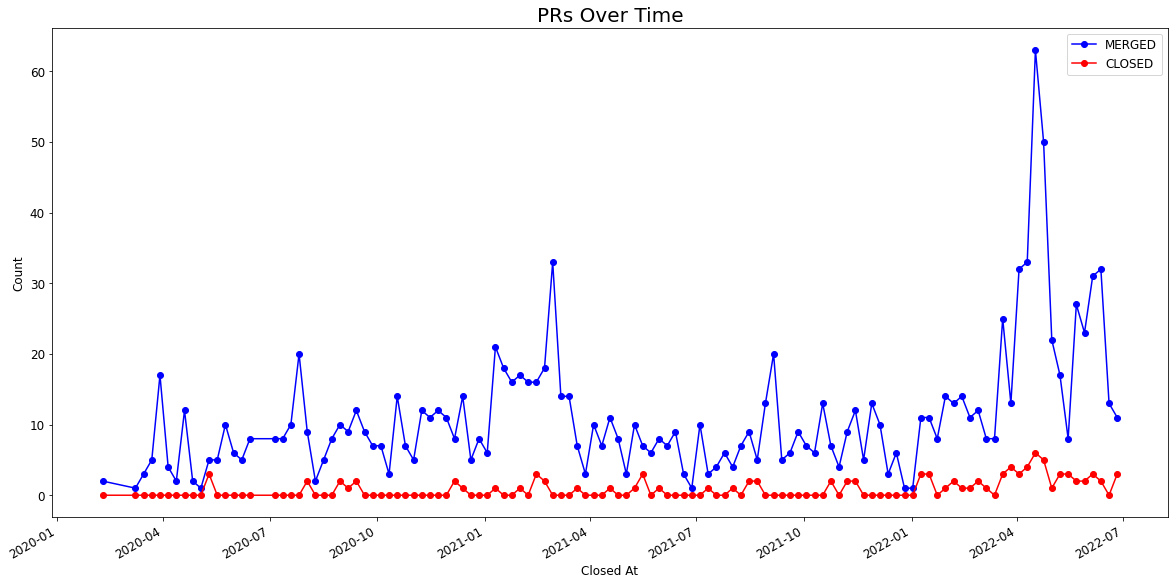

In [261]:
# Count CLOSED/MERGED items per week
weekly_prs = prs.set_index('closedAt').groupby(
    [pd.Grouper(freq='W', label='left'), pd.Grouper('state')])['state'].count().reset_index(name='count')

# Pivot into column by state
weekly_prs = weekly_prs.pivot(
    index='closedAt', columns='state', values='count').unstack()

# Replace NaN
weekly_prs['CLOSED'] = weekly_prs['CLOSED'].fillna(0)
weekly_prs['MERGED'] = weekly_prs['MERGED'].fillna(0)

plt.figure(figsize=(20, 10), facecolor='white')
plt.title('PRs Over Time', fontsize=20)
weekly_prs['MERGED'].plot(color='blue', marker='o',
                          label='MERGED', legend=True)
weekly_prs['CLOSED'].plot(color='red', marker='o', label='CLOSED', legend=True)
plt.ylabel('Count')
plt.xlabel('Closed At')
plt.show()
